In [1]:
%pylab inline
from numpy.linalg import matrix_power
from matplotlib import animation, rc
rc('animation', html='html5')

Populating the interactive namespace from numpy and matplotlib


In [2]:
boardlen = 100
transition_matrix = np.zeros((boardlen, boardlen))
bounce = 0

In [3]:
# encoding rolls of die
for space in range(boardlen):
    if space < (boardlen - 6):
        transition_matrix[space, np.arange(space+1, space+7)] = 1/6
    elif space == boardlen - 1:  # end, absorbing state
         transition_matrix[space, space] = 1
    elif bounce:
        # this should be checked more carefully. This is the "bounce-off" behaviour.
        transition_matrix[space, (space+1):] = 1/6
        transition_matrix[space, (boardlen-(6 - (boardlen-space-2))):boardlen-1] += 1/6
    else:
        transition_matrix[space,(space+1):] = 1/6
        transition_matrix[space, space] += (space - boardlen + 7)/6

In [4]:
# defining snakes and ladders as ordered start and end points
snakes = [[16, 6],
          [86, 23],
          [98, 77],
          [63, 59],
          [61, 18],
          [94, 74],
          [92, 72],
          [53, 33]]

ladders = [[3,13],
          [8,30],
          [19,37],
          [27,83],
          [39,59],
          [50,66],
          [62,80],
          [70,90]]

# The difference between a snake and a ladder is purely semantic, 
# so we'll make the snakes_n_ladders a single array that defines a given playboard.
snakes_n_ladders = array(snakes+ladders)

# You can never end a turn on the start of a snake/ladder, you instead move to its endpoint
for start, end in snakes_n_ladders:
    transition_matrix[:,end] += transition_matrix[:,start]
    transition_matrix[:,start] = 0

In [53]:
# An array of the first 500 turns, and the P of winning on each turn
current_ps = transition_matrix
winarray = [[1, 0.0, 0.0]]
for turn in range(500):
    prev_ps = current_ps
    current_ps = matmul(current_ps, transition_matrix)
    winarray.append([int(turn + 1), current_ps[0,99]-prev_ps[0,99], current_ps[0,99]])
else:
    winarray = array(winarray)

In [55]:
winarray

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  4.98000000e+02,   2.99311612e-07,   9.99987322e-01],
       [  4.99000000e+02,   2.92408342e-07,   9.99987614e-01],
       [  5.00000000e+02,   2.85664288e-07,   9.99987900e-01]])

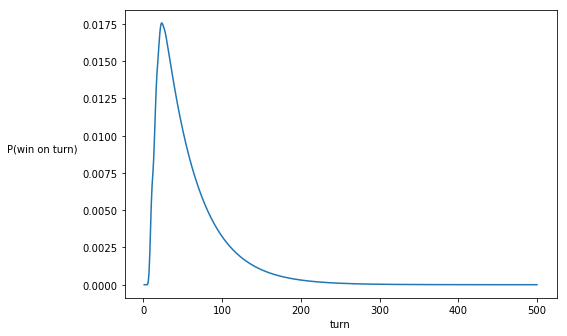

In [69]:
# a quick plot of the odds of winning on each turn

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel("P(win on turn)", rotation = 0, labelpad = 40)
ax.set_xlabel("turn")

ax.plot(winarray[:,0],winarray[:,1]);

In [70]:
# The density_at_turn function will map the likelihood of being each space after a given number of turns
# Defaults to assuming a start on space 0
def density_at_turn(turn, start=0):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel("P", rotation = 0, labelpad = 25)
    ax.set_xlabel("Space")

    rects = bar(np.arange(boardlen), matrix_power(transition_matrix, turn)[start]);
    return fig

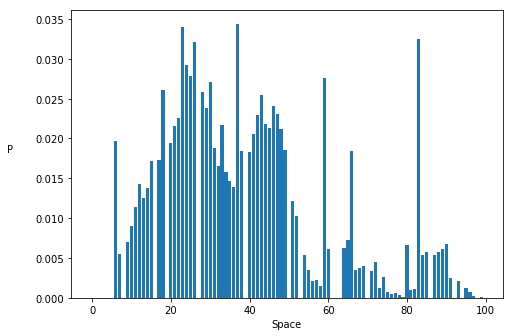

In [71]:
# Note the impossibility of being on spaces 0-5 after 6 turns
density_at_turn(7);

# Let's make a movie!

This function will animate the probabilities of a player being on each space as the turns go on

In [8]:
def animate_snl(transition_mat, frames=500, interval=100):
    fig = plt.figure(figsize = (12, 4))
    ax = fig.add_subplot(1,1,1)
    #fig, ax = plt.subplots()
    ax.set_ylabel("P", rotation = 0, labelpad = 25)
    ax.set_xlabel("Space")
    rects = list(bar(np.arange(boardlen)+1, transition_matrix[0]))
    ax.set_ylim([0,0.16])
    ax.set_xlim([1,100])
    plt.close()
    
    time_text = ax.text(2, 0.12, '', fontsize=15)
    
    def init():
        return rects
    
    def animate(i):
        if i==0:
            prev_p = p_won_ever = p_won_now = animate.current_matrix[0,99]
        else:
            prev_p = animate.current_matrix[0,99]

            animate.current_matrix = matmul(animate.current_matrix, transition_matrix)

            p_won_ever = animate.current_matrix[0, 99]
            p_won_now = (p_won_ever - [prev_p])[0]
        
        for rectangle, h in zip(rects, animate.current_matrix[0]):
            rectangle.set_height(h)
            
        time_text.set_text("Turn: "+str(i+1)+"\nP(Win this turn) = "
                           + str(p_won_now.round(6)) +"\nP(won) = "
                           + str(p_won_ever.round(3))+ "")


        return rects
    
    animate.current_matrix = transition_matrix
    fig.tight_layout(h_pad=5)
    anim = animation.FuncAnimation(fig, animate, init_func = init, 
                                   frames = frames, interval = interval, 
                                   blit=True)
    return anim

In [9]:
animate_snl(transition_matrix, frames = 150, interval = 200)